# Programming Assignment-2
The goal of this assingment is to allow you to practice several the following things in Python:
1. Perfoming typical data processing (or preprocessing if you prefer). This includes all the typical data wraning such as creating news variables, combining several datasets and more 
2. Running explolatory data analysis including basic plotting of variables 
3. Perfoming basic inferential statisticals using statsmodels and scipy to run hypythesis testing and build simple statistial or econometric models.

## Datasets 
For this assignment, you will use the following datasets:
### Rwanda Health Indicators
The Excel file was generated by combining multiple CSV files, each containing data on different health indicators for Rwanda, So that each sheet in the file represent one such indicator. See below some of the input files which were used:
- `access-to-health-care_subnational_rwa`
- `child-mortality-rates_subnational_rwa`
- `dhs-mobile_subnational_rwa`

You can download the dataset from [here](https://docs.google.com/spreadsheets/d/1uvTQYS22VfXXo1Hwkm1frFx_bKkLQkcf/edit?usp=share_link&ouid=113302179168925233984&rtpof=true&sd=true).
### Nights lights Data
- Please download it [here](https://drive.google.com/file/d/1f_4fiqxIejly0YmC088s9bxOfrABv9Sz/view?usp=sharing) and check the documentation in the cells below. 

### Popupation Dataset
- Please download it [here](https://drive.google.com/file/d/1FWEFGdN-xDuFH1jmt0hr4F8Xc3Y5XzvB/view?usp=share_link) and check the documentation and metadata in the class notebooks.


## Submission Guidelines 
- Please guidelines and complete all steps in the [GitHub Workflow](https://dmatekenya.github.io/AIMS-DSCBI/course-requirements/github-workflow.html)
- Once you have completed your assignment, push chanegs to your repository.
- Send a link (copy from within GitHub) to your notebook to the tutors/teaching assistants


# Import Required Packages

In [1]:
from pathlib import Path
import pandas as pd

# Setup Input Folders

As usual, it is good practice to set up input folders using the [`pathlib`](https://docs.python.org/3/library/pathlib.html) package. In this section, make sure to define the folders where your data is stored on your machine.

I find it helpful to set up the working directory and input data folders right at the start of the notebook. To keep things organized, I use the naming convention: `FILE_{NAME}` for files and `DIR_{NAME}` for folders. We use capital letters because these are global variables that will be referenced throughout the notebook.

We'll be using the [`pathlib`](https://docs.python.org/3/library/pathlib.html) library, which offers several advantages over traditional string-based path handling:

- **Cross-platform compatibility** - automatically handles path separators (`/` vs `\`) across different operating systems
- **Object-oriented approach** - paths are objects with useful methods rather than strings
- **Intuitive syntax** - use `/` operator to join paths naturally: `parent_dir / "subfolder" / "file.txt"`
- **Built-in path operations** - methods like `.exists()`, `.is_file()`, `.parent`, `.stem`, and `.suffix`
- **Safer path manipulation** - reduces errors from manual string concatenation and splitting

This is the recommended approach for managing file paths in modern Python development.


In [2]:
# Uncomment the following lines and add your code to define the directories and files
DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_EXCEL = DIR_DATA/"RW-Health-Data.xlsx"

# Population by enumeration area (EA) for Malawi
# FILE_POP_MW = ADD YOUR CODE


# Part 1: Processing Excel Files
The primary goal is to preprocess an [Excel file](https://docs.google.com/spreadsheets/d/1uvTQYS22VfXXo1Hwkm1frFx_bKkLQkcf/edit?usp=share_link&ouid=113302179168925233984&rtpof=true&sd=true) with multiple sheets into a unified CSV dataset that consolidates multiple indicators. Having all indicators in a single file at the same analytical unit (national, subnational) is more efficient than managing separate files and enables easier cross-indicator analysis.

## Task 1: Generate National-Level Summaries

For each indicator, compute a single national-level value using appropriate aggregation functions such as **mean**, **sum** or **count**. For this one, all available indicators can be summarized at national level, so we will have a CSV file with one row and 

### Expected Output Structure
1. **DataFrame display** in Jupyter Notebook
2. **CSV file** with columns:
- `indicator_name`: Name of the indicator
- `aggregated_value`: Computed national value
- `indicator_year`: Survey year or something similar
- `survey_name`: Name of the survey where information is coming from
- `aggregation_method`: Statistical method used (optional)

## Task 2: Subnational-Level Indicator Dataset

Create a merged dataset for indicators with subnational data (ADM2/ADM3 levels), ensuring spatial alignment and consistent administrative boundaries.

### Expected Output Structure
   - `indicator_name`: Name of the indicator
   - `aggregated_value`: Computed national value
   - `indicator_year`: Survey year or something similar
   - `survey_name`: Name of the survey where information is coming from
   - `aggregation_method`: Statistical method used (optional)

This structure enables both single-indicator and multi-indicator analysis at the subnational level.

QUESTION 1 -  Task 1: Generate National-Level Summaries

In [ ]:
xls = pd.ExcelFile(FILE_EXCEL)
sheet_names = xls.sheet_names

# Define aggregation rules per indicator if needed
# (default is mean if indicator is not listed)
aggregation_rules = {
    # Example:
    # 'Population': 'sum',
    # 'Number of facilities': 'count'
}

results = []

for sheet in sheet_names:
    df = pd.read_excel(FILE_EXCEL, sheet_name=sheet)

    # Drop metadata row if present
    if '#indicator+value+num' in str(df.iloc[0].get('Value', '')):
        df = df.iloc[1:].copy()

    # Convert Value to numeric and drop invalid rows
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    df = df.dropna(subset=['Value', 'Indicator'])

    indicators = df['Indicator'].unique()

    for ind in indicators:
        sub_df = df[df['Indicator'] == ind]

        # Choose aggregation method
        agg_method = aggregation_rules.get(ind, 'mean')
        if agg_method == 'mean':
            value = sub_df['Value'].mean()
        elif agg_method == 'sum':
            value = sub_df['Value'].sum()
        elif agg_method == 'count':
            value = sub_df['Value'].count()
        else:
            value = sub_df['Value'].mean()  # fallback

        year = sub_df['SurveyYear'].mode().iloc[0] if not sub_df['SurveyYear'].isna().all() else None
        survey_id = sub_df['SurveyId'].mode().iloc[0] if not sub_df['SurveyId'].isna().all() else None
        survey_type = sub_df['SurveyType'].mode().iloc[0] if 'SurveyType' in sub_df.columns and not sub_df['SurveyType'].isna().all() else None

        results.append({
            'indicator_name': ind,
            'aggregated_value': value,
            'indicator_year': year,
            'survey_name': survey_id,
            'survey_type': survey_type,
            'aggregation_method': agg_method
        })

#Combine results into a DataFrame
custom_national_summary = pd.DataFrame(results)

# Save to CSV file
output_file = "national_summary_file.csv"
custom_national_summary.to_csv(output_file, index=False)

# Display the DataFrame (Jupyter Notebook)
custom_national_summary.head()

,indicator_name,aggregated_value,indicator_year,survey_name,survey_type,aggregation_method
0,Total fertility rate 15-49,5.269697,2000,RW2000DHS,DHS,mean
1,General fertility rate,168.727273,2000,RW2000DHS,DHS,mean
2,Median age at first birth for women age 25-49,22.103571,2000,RW2000DHS,DHS,mean
3,Women who want no more children,40.468000,2000,RW2000DHS,DHS,mean
4,Mean ideal number of children for all women,4.141071,2000,RW2000DHS,DHS,mean


QUESTION 1 - Task 2: Subnational-Level Indicator Dataset

In [24]:
from pathlib import Path

import pandas as pd
import re


# 1. Load workbook and identify sheets with subnational data


DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_EXCEL = DIR_DATA/"RW-Health-Data.xlsx"

# Load the Excel file

xls = pd.ExcelFile(FILE_EXCEL)
sheet_names = xls.sheet_names

# Remove the first row (metadata)


# Sheets considered ADM2/ADM3 = anything containing the phrase "subnation" (customize if needed)
subnational_sheets = [s for s in xls.sheet_names if re.search(r"subnation", s, re.IGNORECASE)]


# 2. Function to load & clean each sub-national sheet

def load_and_clean(sheet_name):
    df = pd.read_excel(xls, sheet_name=sheet_name)

    # Standardize column names (lowercase, no spaces)
    df.columns = df.columns.str.strip().str.lower().str.replace(r"\s+", "_", regex=True)

    # Ensure we have a 'location' column or equivalent (ADM2/ADM3 identifier)
    # Some sheets may label it differently – handle cases here:
    possible_loc_cols = ['location', 'characteristiclabel']
    loc_col = None
    for col in possible_loc_cols:
        if col in df.columns:
            loc_col = col
            break

    if loc_col is None:
        raise ValueError(f"Location column not found in {sheet_name}")

    # Clean the location names (trim, lowercase)
    df[loc_col] = df[loc_col].astype(str).str.strip().str.lower()

    # Keep only needed columns
    keep = [loc_col, "indicator", "value"]
    df = df[[c for c in keep if c in df.columns]]

    # Add a sheet identifier to track survey name
    df["survey_name"] = sheet_name

    return df.rename(columns={loc_col: "adm_location"})


# 3. Load, clean, and append all ADM2/ADM3 datasets

frames = []
possible_location_cols = ['location', 'characteristiclabel']
for s in subnational_sheets: 
    f = load_and_clean(s)
    frames.append(f)
    

def load_and_clean(sheet_name):
    df = xls.parse(sheet_name)

    # remove metadata row if needed
    # df = df.iloc[1:].reset_index(drop=True)

    # detect location column (flexible check)
    loc_col = None
    for c in df.columns:
        if c.strip().lower() in possible_location_cols:
            loc_col = c
            break

    if loc_col is None:
        raise ValueError(f"Location column not found in {sheet_name}")

    # clean & normalize
    df[loc_col] = df[loc_col].astype(str).str.strip().str.lower()
    df["indicator_name"] = sheet_name
    df["survey_name"] = sheet_name

    return df.rename(columns={loc_col: "adm_location"})
f = load_and_clean(s)
frames.append(f)

merged_df = pd.concat(frames, ignore_index=True)

merged_df = merged_df.iloc[1:].reset_index(drop=True)


pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)



# 4. Preview and save

# Save the modified data to a new CSV file


merged_df.to_csv("merged_subnational_indicators.csv", index=False)
print(merged_df)
print("Merged dataset saved to merged_subnational_indicators.csv")


          adm_location                   indicator value  \
0      butare/gitarama  Total fertility rate 15-49   5.2   
1               butare  Total fertility rate 15-49   4.8   
2             gitarama  Total fertility rate 15-49   5.5   
3       byumba/kibungo  Total fertility rate 15-49   6.4   
4               byumba  Total fertility rate 15-49   6.2   
...                ...                         ...   ...   
19459           kigali                         NaN   NaN   
19460            south                         NaN   NaN   
19461             west                         NaN   NaN   
19462            north                         NaN   NaN   
19463             east                         NaN   NaN   

                        survey_name ISO3   DataId  \
0        dhs-mobile_subnational_rwa  NaN      NaN   
1        dhs-mobile_subnational_rwa  NaN      NaN   
2        dhs-mobile_subnational_rwa  NaN      NaN   
3        dhs-mobile_subnational_rwa  NaN      NaN   
4        dhs-m

## Introduction to Nightlights Dataset

## What is Nightlight Data?

Nightlight data is satellite imagery capturing artificial light emissions from Earth's surface during nighttime. Satellites like VIIRS collect this data regularly, providing an **objective, real-time measure of human economic activity and development**.

### Raw Data: Radiance Measurements
The fundamental measurement in nightlight data is **radiance** - the amount of light energy detected by satellite sensors, measured in **nanowatts per square centimeter per steradian (nW/cm²/sr)**. Each pixel in satellite imagery contains a radiance value representing the light intensity from that specific location on Earth's surface.

### Annual Composite Generation
This dataset was created from **annual composite images** using VIIRS nightlight files for Rwanda. Annual composites are generated by:

- **Aggregating daily/monthly observations** throughout each year (2015, 2020, 2024)
- **Filtering out temporary light sources** (fires, lightning, aurora)
- **Removing cloud-affected observations** to ensure clear measurements
- **Averaging or taking median values** to create stable, representative annual measurements
- **Masking techniques** to exclude areas with unreliable data

The files used include both **average composites** (`average_masked`) and **median composites** (`median_masked`), with **cloud-free versions** (`vcmslcfg`) preferred over cloud-inclusive versions (`vcmcfg`) for more accurate measurements.

### Why Use Nightlight Data?

- **Consistent global coverage** - Available everywhere, regardless of local data quality
- **Real-time updates** - More current than traditional economic statistics
- **Objective measurement** - Not subject to reporting biases
- **High resolution** - Captures local development patterns
- **Proxy for development** - Light intensity correlates with economic activity, infrastructure, and quality of life

## Dataset Overview 

- **6,507 observations** across Rwanda's administrative cells
- **Three time periods**: 2015, 2020, 2024
- **Cell-level data** - Rwanda's smallest administrative units
- Allows temporal analysis of development trends

---

## Variable Definitions

### Administrative Identifiers
- **`cell_id`** - Unique identifier for linking with other datasets
- **`province_name`** - Province (5 total in Rwanda)
- **`district_name`** - District (30 total in Rwanda) 
- **`sector_name`** - Administrative level between district and cell
- **`cell_name`** - Specific cell name

### Core Nightlight Measurements

#### `total_nightlight`
- **Sum of all radiance values** within cell boundaries
- **Key indicator** of overall economic activity/development
- Higher values = more total development

#### `mean_nightlight` 
- **Average radiance** per pixel
- Indicates development intensity regardless of cell size
- Useful for comparing cells of different areas

#### `median_nightlight`
- **Middle radiance value** of all pixels (less sensitive to outliers)
- Better represents typical lighting in unevenly developed areas

#### `max_nightlight`
- **Highest radiance** within cell
- Indicates major infrastructure (hospitals, commercial centers)

#### `min_nightlight` & `std_nightlight`
- Minimum radiance and standard deviation
- High std = uneven development within cell

### Spatial Coverage Indicators

#### `pixel_count`
- **Total pixels** in cell (indicates geographic size)
- Used to normalize other measurements

#### `lit_pixel_count`
- **Number of pixels with detectable light** (radiance > 0)
- Shows spatial extent of development

#### `lit_pixel_percentage`
- **Percentage of cell area with lighting**
- Formula: `(lit_pixel_count ÷ pixel_count) × 100`
- **0% = completely dark, 100% = fully developed**

#### `year`
- Time period: 2015, 2020, or 2024

# Part-2: Demographic and Nightlights Data

## Part A: Varible Generation and Data Integration

### Population Dataset Variables (`rwa-cell-pop.csv`):
Create the following derived variables:
- **`dependency_ratio`** - `(children_under_five_2020 + elderly_60_plus_2020) / working_age_population * 100`
- **`people_per_building`** - `general_2020 / building_count`
- **`working_age_population`** - `general_2020 - children_under_five_2020 - elderly_60_plus_2020`
- **`infrastructure_index`** - Your own formula that incorporates `people_per_building` and other relevant variables to measure infrastructure adequacy. Document and justify your `infrastructure_index` methodology, explaining how `people_per_building` and other variables contribute to measuring infrastructure pressure.

### Nightlight Dataset Variables (`cell-ntl-2015-2020-2024.csv`):
Create the following temporal and development indicators:
- **`nightlight_change_2015_2024`** - Percentage change in total nightlight from 2015 to 2024
- **`mean_nightlight_change_2015_2024`** - Percentage change in mean nightlight from 2015 to 2024
- **`lit_pixel_percentage`** - Use existing or calculate: `(lit_pixel_count / pixel_count) * 100`

### Data Integration:
Merge the datasets using the appropriate column. 

## Part B: Exploratory Data Analysis

### Correlation Analysis:
1. **Correlation Heatmap**: Create a heatmap showing correlations between 10 key variables (mix of demographic, infrastructure, and nightlight variables). 
2. **Report the top 3 variable pairs** with the highest correlations and interpret their relationships.
3. **Identify unexpected correlations** and discuss potential explanations.

### Nightlight Trend Analysis:
1. **District Ranking**: Report the **top 5 districts** with the highest nightlight growth (2015-2024) and **bottom 5 districts** with the most decline or lowest growth.
2. **Lit Pixel Analysis**: Compare these districts using `lit_pixel_percentage` changes to understand whether growth represents intensification or spatial expansion.
3. **Create visualizations** showing nightlight trends for these extreme districts.

## Part C: Modeling

### Multivariate Linear Regression:
1. **Model Development**: Build a multivariate linear regression model predicting **population density** using both demographic and nightlight variables as predictors. Explore as many variables as possible at the beginning.
2. **Variable Selection**: Test different combinations of variables and report the **top 3 most predictive variables** of population density.
3. **Model Evaluation**: Report R-squared, coefficients, and statistical significance. Interpret what these results tell us about population-infrastructure relationships.



## Notes and Other Requirements
Please follow the genral guidelines below when preparing your analysis..

### Statistical Analysis:
- Properly handle missing data and outliers
- Use appropriate statistical tests and report p-values
- Calculate and interpret correlation coefficients
- Validate regression assumptions (normality, homoscedasticity)

### Data Management:
- Document all data cleaning and aggregation steps using markdown 
- Ensure consistent district naming across datasets

### Visualization Standards:
- Create clear, publication-quality heatmaps with appropriate color scales
- Design effective time series plots for nightlight trends
- Include proper axis labels, titles, and legends
- Use consistent formatting across all visualizations

### Reporting Requirements:
- Clearly state the top 3 most predictive variables with statistical justification
- Provide ranked lists for nightlight growth districts with supporting metrics
- Include model performance statistics and interpretation
- Document all methodological choices and assumptions

QUESTION 2: DEMOGRAPHIC AND NIGHTLIGHTS DATA

QUESTION 2 PART A - Variable Generation and Data Integration

Population Dataset Variables (rwa-cell-pop.csv)

In [ ]:
from pathlib import Path
import pandas as pd


# Setup display options for clean preview

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

# Load data

DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_RWA_CELL = DIR_DATA/"rwa-cell-pop.csv"
df = pd.read_csv(FILE_RWA_CELL)


# 1. Working-age population

df['working_age_population'] = (
    df['general_2020'] - df['children_under_five_2020'] - df['elderly_60_plus_2020']
)

# 2. Dependency ratio

df['dependency_ratio'] = (
    (df['children_under_five_2020'] + df['elderly_60_plus_2020'])
    / df['working_age_population']
) * 100

# 3. People per building

df['people_per_building'] = df['general_2020'] / df['building_count']

# 4. Infrastructure index (robust normalization)

ppb_min = df['people_per_building'].min()
ppb_max = df['people_per_building'].max()

# Prevent division by zero
if ppb_max == ppb_min:
    df['ppb_norm'] = 0
else:
    df['ppb_norm'] = (df['people_per_building'] - ppb_min) / (ppb_max - ppb_min)

# Weighted index (adjust weights if needed)
df['infrastructure_index'] = 0.6 * df['ppb_norm'] + 0.4 * (df['dependency_ratio'] / 100)


# Select only the relevant columns

cols_to_export = [
    'cell_id', 'general_2020', 'building_count',
    'working_age_population', 'dependency_ratio',
    'people_per_building', 'infrastructure_index'
]
df_subset = df[cols_to_export]


# Preview & save

#print(df_subset.head())
df_subset.to_csv("rwa-cell-pop_with_derived_variables.csv", index=False)
print(df_subset.head(3))
print("Saved to rwa-cell-pop_with_derived_variables.csv")


         cell_id  general_2020  building_count  working_age_population  \
0  RWA.1.1.1.1_1   3855.623385          1435.0             3118.507497   
1  RWA.1.1.1.2_1   3669.128833           884.0             2968.862111   
2  RWA.1.1.1.3_1   1756.630395           530.0             1421.723064   

   dependency_ratio  people_per_building  infrastructure_index  
0         23.636816             2.686846              0.094547  
1         23.587041             4.150598              0.094348  
2         23.556439             3.314397              0.094226  
Saved to rwa-cell-pop_with_derived_variables.csv


SUMMARY OF THE METHODOLOGY ON INFRASTRUCTURE INDEX

A composite indicator called the infrastructure_index is used to evaluate the strain on essential services and infrastructure at the subnational level. It incorporates built-environment and demographic factors to show how well the current infrastructure satisfies the needs of the populace.

*Fundamental Logic:

When there are more people living in each unit of infrastructure and/or a larger percentage of dependents (elderly and young children) who require more on services, infrastructure demand tends to increase.

The index combines in order to capture this idea:

- The number of people serviced per building is a measure of crowding.
- The dependency ratio is a measure of demographic burden.

(As new variables become available, they can be included to increase index sensitivity; they include road density, school or health facility counts, and access to water sites.)

Summary
A composite indicator called the infrastructure_index is used to evaluate the strain on essential services and infrastructure at the subnational level. 

*people_per_building: Higher values = more people sharing a single building → potential overcrowding

*working_age_population: Population theoretically able to work/support dependents

*dependency_ratio: Higher values = more non-working dependents per working-age adult


QUESTION 2 PART A - Nightlight Dataset Variables (cell-ntl-2015-2020-2024.csv):

In [1]:
import pandas as pd
from pathlib import Path

# Paths
DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_NIGHT_RW = DIR_DATA / "cell-ntl-2015-2020-2024.csv"
OUTPUT_FILE = DIR_DATA / "rw-cell-nightlight_file.csv"

# Load data
df = pd.read_csv(FILE_NIGHT_RW)

# Keep only 2015 & 2024
df_filtered = df[df['year'].isin([2015, 2024])].copy()

# Pivot so each cell_id has 2015 & 2024 on a single row
pivot = df_filtered.pivot(index='cell_id', columns='year', values=['total_nightlight','mean_nightlight','lit_pixel_count','pixel_count'])

# Drop cells missing either 2015 or 2024
pivot = pivot.dropna(subset=[('total_nightlight',2015), ('total_nightlight',2024)])

# Compute indicators
out = pd.DataFrame(index=pivot.index)
out['nightlight_change_2015_2024'] = ( (pivot[('total_nightlight',2024)] - pivot[('total_nightlight',2015)]) / pivot[('total_nightlight',2015)] ) * 100
out['mean_nightlight_change_2015_2024'] = ( (pivot[('mean_nightlight',2024)] - pivot[('mean_nightlight',2015)]) / pivot[('mean_nightlight',2015)]) * 100
out['lit_pixel_percentage'] = ( pivot[('lit_pixel_count',2024)] / pivot[('pixel_count',2024)] ) * 100

# Reset index so cell_id is a column
out = out.reset_index()

# Display
out.head(10)


,cell_id,nightlight_change_2015_2024,mean_nightlight_change_2015_2024,lit_pixel_percentage
0,RWA.1.1.1.1_1,510.862720,510.862733,37.142857
1,RWA.1.1.1.2_1,601.012355,601.012330,42.857143
2,RWA.1.1.1.3_1,599.043610,599.043614,43.333333
3,RWA.1.1.1.4_1,534.552323,534.552310,43.434343
4,RWA.1.1.10.1_1,539.337363,539.337358,46.000000
5,RWA.1.1.10.2_1,974.938919,974.938854,53.977273
6,RWA.1.1.10.3_1,558.826407,558.826416,38.750000
7,RWA.1.1.10.4_1,560.485817,560.485793,45.562130
8,RWA.1.1.11.1_1,466.769264,466.769256,45.454545
9,RWA.1.1.11.2_1,704.340402,704.340334,18.636364


QUESTION 2 PART A - Data Integration

Merge the datasets using the appropriate column

In [11]:
import pandas as pd
from pathlib import Path

# 1. Load the original nightlight dataset
DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_NTL = DIR_DATA / "cell-ntl-2015-2020-2024.csv"
df = pd.read_csv(FILE_NTL)

# 2. Process rows for only 2015 and 2024
df_pivot = (
    df[df['year'].isin([2015, 2024])]
      .pivot(index='cell_id', columns='year')
)
df_pivot.columns = [f"{col}_{yr}" for col, yr in df_pivot.columns]

# 3. Compute indicators
df_pivot['nightlight_change_2015_2024'] = (
    (df_pivot['total_nightlight_2024'] - df_pivot['total_nightlight_2015']) /
    df_pivot['total_nightlight_2015'] * 100
)

df_pivot['mean_nightlight_change_2015_2024'] = (
    (df_pivot['mean_nightlight_2024'] - df_pivot['mean_nightlight_2015']) /
    df_pivot['mean_nightlight_2015'] * 100
)


df_pivot['lit_pixel_percentage'] = (
    df_pivot['lit_pixel_count_2024'] / df_pivot['pixel_count_2024']
) * 100


inds = df_pivot[['nightlight_change_2015_2024',
                 'mean_nightlight_change_2015_2024',
                 'lit_pixel_percentage']].reset_index()

# 4. Merge indicators back into the original dataframe
merged_df = df.merge(inds, on='cell_id', how='left')

# 5. Drop unwanted admin columns
merged_df = merged_df.drop(columns=['province_name', 'district_name', 'sector_name'])

#6. Save the merged dataframe to a CSV file
output_file = DIR_DATA / "merged_df.csv"
merged_df.to_csv(output_file, index=False)
print(f"Saved to {output_file}")

#7. Display the first 6 rows of the merged dataframe
merged_df.head(6)

Saved to /Users/ekayitaba/Library/CloudStorage/Dropbox/Mac/Documents/GitHub/AIMS-DSCBI/data/merged_df.csv


,cell_id,prov_name,dist_name,sect_name,cell_name,total_nightlight,mean_nightlight,median_nightlight,max_nightlight,min_nightlight,std_nightlight,pixel_count,lit_pixel_count,year,lit_pixel_percentage_x,nightlight_change_2015_2024,mean_nightlight_change_2015_2024,lit_pixel_percentage_y
0,RWA.1.1.1.1_1,Amajyaruguru,Burera,Bungwe,Bungwe,6.994746,0.099925,0.0,0.300291,0.0,0.130675,70,26,2020,37.142857,510.862720,510.862733,37.142857
1,RWA.1.1.1.1_1,Amajyaruguru,Burera,Bungwe,Bungwe,11.608531,0.165836,0.0,0.586523,0.0,0.218413,70,26,2024,37.142857,510.862720,510.862733,37.142857
2,RWA.1.1.1.1_1,Amajyaruguru,Burera,Bungwe,Bungwe,1.900350,0.027148,0.0,0.142328,0.0,0.038462,70,26,2015,37.142857,510.862720,510.862733,37.142857
3,RWA.1.1.1.2_1,Amajyaruguru,Burera,Bungwe,Bushenya,7.167736,0.113774,0.0,0.307715,0.0,0.131960,63,27,2020,42.857143,601.012355,601.012330,42.857143
4,RWA.1.1.1.2_1,Amajyaruguru,Burera,Bungwe,Bushenya,10.771848,0.170982,0.0,0.463222,0.0,0.198171,63,27,2024,42.857143,601.012355,601.012330,42.857143
5,RWA.1.1.1.2_1,Amajyaruguru,Burera,Bungwe,Bushenya,1.536613,0.024391,0.0,0.105445,0.0,0.030171,63,27,2015,42.857143,601.012355,601.012330,42.857143


QUESTION 2 PART B - Exploratory Data Analysis

QUESTION 2 PART B - Correlation Analysis

1. Correlation Heatmap

Saved: /Users/ekayitaba/Library/CloudStorage/Dropbox/Mac/Documents/GitHub/AIMS-DSCBI/data/correlation_10_variables.csv


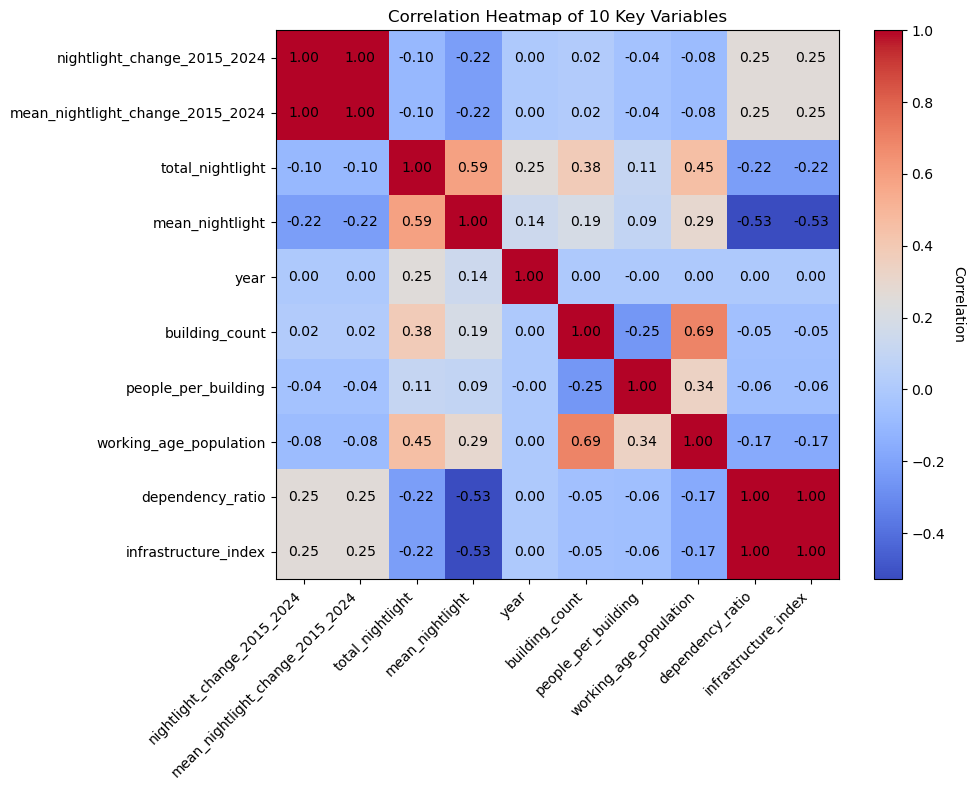

In [12]:
# Correlation prep + heatmap for 10 key variables
# - Merges three CSVs on `cell_id`
# - Keeps exactly the requested 10 columns
# - Saves merged data to correlation_10_variables.csv
# - Displays a correlation heatmap (matplotlib only)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# 1) Paths & load data

DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_NEWVAR     = DIR_DATA / "newvar_cell-ntl-2015-2020-2024.csv"
FILE_MERGED_DF  = DIR_DATA / "merged_df.csv"
FILE_DERIVED    = DIR_DATA / "rwa-cell-pop_with_derived_variables.csv"

df_newvar  = pd.read_csv(FILE_NEWVAR)
df_merged  = pd.read_csv(FILE_MERGED_DF)
df_derived = pd.read_csv(FILE_DERIVED)


# 2) Keep required columns only

newvar_cols  = ['cell_id', 'nightlight_change_2015_2024', 'mean_nightlight_change_2015_2024']
merged_cols  = ['cell_id', 'total_nightlight', 'mean_nightlight', 'year']
derived_cols = ['cell_id', 'building_count', 'people_per_building', 'working_age_population',
                'dependency_ratio', 'infrastructure_index']

df_newvar_sel  = df_newvar[newvar_cols].copy()
df_merged_sel  = df_merged[merged_cols].copy()
df_derived_sel = df_derived[derived_cols].copy()


# 3) Merge on cell_id (inner)
#     Note: If merged_df has multiple years per cell_id,
#     this will duplicate newvar/derived rows for each year for that cell.

merged_all = (
    df_newvar_sel
    .merge(df_merged_sel, on='cell_id', how='inner')
    .merge(df_derived_sel, on='cell_id', how='inner')
)


# 4) Reorder to exactly the 10 requested columns and save

keep_cols = [
    'nightlight_change_2015_2024',
    'mean_nightlight_change_2015_2024',
    'total_nightlight',
    'mean_nightlight',
    'year',
    'building_count',
    'people_per_building',
    'working_age_population',
    'dependency_ratio',
    'infrastructure_index'
]
merged_all = merged_all[keep_cols].copy()

# Ensure numeric dtypes for correlation
for c in keep_cols:
    merged_all[c] = pd.to_numeric(merged_all[c], errors='coerce')

# Drop rows where *all* 10 variables are NaN (optional safety)
merged_all = merged_all.dropna(how='all', subset=keep_cols)

# Save the merged 10-variable dataset
OUT_FILE = DIR_DATA / "correlation_10_variables.csv"
merged_all.to_csv(OUT_FILE, index=False)
print(f"Saved: {OUT_FILE}")


# 5) Correlation + heatmap (matplotlib only)

corr = merged_all.corr(numeric_only=True)


fig, ax = plt.subplots(figsize=(10, 8))

# Choose colormap: 'coolwarm', 'plasma', 'inferno', 'Blues', 'RdBu', etc.
im = ax.imshow(corr, aspect='auto', cmap='coolwarm')  

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom")


# Axis ticks & labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.index)

# Annotate each cell with the correlation value
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr.iloc[i, j]
        if pd.notna(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center")

ax.set_title("Correlation Heatmap of 10 Key Variables")
fig.tight_layout()
plt.show()

QUESTION 2 PART B - Correlation Analysis

2. Top 3 variable pairs with the highest correlations 

In [14]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- 1) Load data ---

DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_CORRELATION = DIR_DATA / "correlation_10_variables.csv"
df = pd.read_csv(FILE_CORRELATION)

# --- 2) Keep only numeric columns for correlations ---
num = df.select_dtypes(include="number")
if num.shape[1] < 2:
    raise ValueError("The dataset must contain at least two numeric columns to compute correlations.")

# --- 3) Correlation matrix ---
corr = num.corr()

# --- 4) Extract unique pairs from the upper triangle (exclude diagonal) and sort by |r| ---
mask = np.triu(np.ones(corr.shape, dtype=bool), k=1)
pairs = (
    corr.where(mask)
        .stack()                       # MultiIndex (col_i, col_j) with correlation values
        .rename("r")
        .sort_values(key=lambda s: s.abs(), ascending=False)
)

# --- 5) Take top 3 by absolute correlation ---
top_n = 3
top = pairs.head(top_n).reset_index()
top.columns = ["variable_a", "variable_b", "r"]

# --- 6) Build human-readable interpretations ---
def strength_label(r: float) -> str:
    ar = abs(r)
    if ar >= 0.9:  return "exceptionally strong"
    if ar >= 0.7:  return "very strong"
    if ar >= 0.5:  return "strong"
    if ar >= 0.3:  return "moderate"
    if ar >= 0.1:  return "weak"
    return "very weak"

def direction_sentence(a: str, b: str, r: float) -> str:
    return (f"As {a} increases, {b} tends to increase."
            if r >= 0 else
            f"As {a} increases, {b} tends to decrease.")

top["strength"] = top["r"].apply(strength_label)
top["direction"] = top["r"].apply(lambda r: "positive" if r >= 0 else "negative")
top["interpretation"] = top.apply(
    lambda x: f"{x['strength'].capitalize()} {x['direction']} correlation (r = {x['r']:.2f}). "
              f"{direction_sentence(x['variable_a'], x['variable_b'], x['r'])}",
    axis=1
)

# --- 7) Print a concise summary ---
print("Top 3 correlation pairs (by |r|):")
for _, row in top.iterrows():
    print(f"- {row['variable_a']} × {row['variable_b']}: r = {row['r']:.3f} — {row['interpretation']}")

# --- 8) Save results to CSV ---
out_path = DIR_DATA /"top3_correlations.csv"
top.to_csv(out_path, index=False)
print(f"\nSaved results to: {out_path}")

Top 3 correlation pairs (by |r|):
- nightlight_change_2015_2024 × mean_nightlight_change_2015_2024: r = 1.000 — Exceptionally strong positive correlation (r = 1.00). As nightlight_change_2015_2024 increases, mean_nightlight_change_2015_2024 tends to increase.
- dependency_ratio × infrastructure_index: r = 1.000 — Exceptionally strong positive correlation (r = 1.00). As dependency_ratio increases, infrastructure_index tends to increase.
- building_count × working_age_population: r = 0.691 — Strong positive correlation (r = 0.69). As building_count increases, working_age_population tends to increase.

Saved results to: /Users/ekayitaba/Library/CloudStorage/Dropbox/Mac/Documents/GitHub/AIMS-DSCBI/data/top3_correlations.csv


PART 2 - B Correlation Analysis

3. Unexpected correlations 

Unexpected correlations (from Correlation Heatmap of 10 Key Variables)

1. mean_nightlight × dependency_ratio (r ≈ -0.53)

Negative correlation: areas with higher average nightlight intensity tend to have lower dependency ratios.

Potential explanation: urbanized, well-lit areas often attract working-age populations (lowering dependency ratio), while rural/dimly lit areas may have more children or elderly (raising dependency ratio).

2. mean_nightlight × infrastructure_index (r ≈ -0.53)

Suggests that areas with high nightlight intensity might paradoxically score lower on the infrastructure index.

Potential explanation: If the index emphasizes crowding (e.g., people per building), then densely lit urban zones could appear as “pressured” despite having more infrastructure.

3. people_per_building × working_age_population (r ≈ 0.34)

Moderate positive correlation: as the working-age population increases, so does crowding per building.

Potential explanation: rapid population growth in urbanizing districts may outpace housing supply, pushing up people-per-building ratios.

QUESTION 2 PART B - Nightlight Trend Analysis

1. District Ranking: Report the top 5 districts with the highest nightlight growth (2015-2024) and bottom 5 districts with the most decline or lowest growth. 

In [30]:
import pandas as pd
from pathlib import Path

# 1. Load the original nightlight dataset

DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_NTL = DIR_DATA / "cell-ntl-2015-2020-2024.csv"
df = pd.read_csv(FILE_NTL)

# 2. Process rows for only 2015 and 2024

df_pivot = (
    df[df['year'].isin([2015, 2024])]
      .pivot(index='cell_id', columns='year')
)
df_pivot.columns = [f"{col}_{yr}" for col, yr in df_pivot.columns]

# 3. Compute indicators

df_pivot['nightlight_change_2015_2024'] = (
    (df_pivot['total_nightlight_2024'] - df_pivot['total_nightlight_2015']) /
    df_pivot['total_nightlight_2015'] * 100
)

df_pivot['mean_nightlight_change_2015_2024'] = (
    (df_pivot['mean_nightlight_2024'] - df_pivot['mean_nightlight_2015']) /
    df_pivot['mean_nightlight_2015'] * 100
)

df_pivot['lit_pixel_percentage'] = (
    df_pivot['lit_pixel_count_2024'] / df_pivot['pixel_count_2024']
) * 100

inds = df_pivot[['nightlight_change_2015_2024',
                 'mean_nightlight_change_2015_2024',
                 'lit_pixel_percentage']].reset_index()

# 4. Merge indicators back into the original dataframe

merged_df = df.merge(inds, on='cell_id', how='left')

# 5. Drop unwanted admin columns

merged_df = merged_df.drop(columns=['province_name', 'district_name', 'sector_name'])


# 6. District-level ranking logic


# Aggregate nightlight_change_2015_2024 at district level (mean growth per district)

district_growth = (
    merged_df.groupby('dist_name')['nightlight_change_2015_2024']
    .mean()
    .reset_index()
    .rename(columns={'nightlight_change_2015_2024': 'mean_growth'})
)

# Top 5 districts with the highest growth

top5 = district_growth.sort_values('mean_growth', ascending=False).head(5)

# Bottom 5 districts with lowest/negative growth

bottom5 = district_growth.sort_values('mean_growth', ascending=True).head(5)

print("TOP 5 DISTRICTS (Highest Nightlight Growth 2015→2024):")
print(top5)

print("\nBOTTOM 5 DISTRICTS (Decline / Lowest Growth):")
print(bottom5)


TOP 5 DISTRICTS (Highest Nightlight Growth 2015→2024):
    dist_name  mean_growth
23  Nyaruguru   877.416033
18  Nyagatare   757.478221
0    Bugesera   716.347835
12     Kirehe   639.036715
15      Ngoma   623.507823

BOTTOM 5 DISTRICTS (Decline / Lowest Growth):
     dist_name  mean_growth
22  Nyarugenge   192.749160
24      Rubavu   318.383571
11    Kicukiro   387.778971
13     Muhanga   390.763713
21      Nyanza   399.027914


QUESTION 2 PART B - Nightlight Trend Analysis

2.1. Lit Pixel Analysis: Compare these districts using lit_pixel_percentage changes to understand whether growth represents intensification or spatial expansion.

In [45]:
import pandas as pd
from pathlib import Path

# 1. Load the original nightlight dataset

DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_NTL = DIR_DATA / "cell-ntl-2015-2020-2024.csv"
df = pd.read_csv(FILE_NTL)

# --- Immediately drop unwanted admin columns at the top ---

#df['dist_name'] = df['district_name']  # preserve
df = df.drop(columns=['province_name', 'district_name', 'sector_name'])

# 2. Process rows for only 2015 and 2024

df_pivot = (
    df[df['year'].isin([2015, 2024])]
      .pivot(index='cell_id', columns='year')
)
df_pivot.columns = [f"{col}_{yr}" for col, yr in df_pivot.columns]

# 3. Compute indicators

df_pivot['nightlight_change_2015_2024'] = (
    (df_pivot['total_nightlight_2024'] - df_pivot['total_nightlight_2015']) /
    df_pivot['total_nightlight_2015'] * 100
)

df_pivot['mean_nightlight_change_2015_2024'] = (
    (df_pivot['mean_nightlight_2024'] - df_pivot['mean_nightlight_2015']) /
    df_pivot['mean_nightlight_2015'] * 100
)

df_pivot['lit_pixel_percentage'] = (
    df_pivot['lit_pixel_count_2024'] / df_pivot['pixel_count_2024']
) * 100

inds = df_pivot[['nightlight_change_2015_2024',
                 'mean_nightlight_change_2015_2024',
                 'lit_pixel_percentage']].reset_index()


# 4. Merge indicators back into the original dataframe

merged_df = df.merge(inds, on='cell_id', how='left')



# 5. District-level ranking logic


# Aggregate nightlight_change_2015_2024 at district level (mean growth per district)

district_growth = (
    merged_df.groupby('dist_name')['nightlight_change_2015_2024']
    .mean()
    .reset_index()
    .rename(columns={'nightlight_change_2015_2024': 'mean_growth'})
)

# Compute average lit_pixel_percentage at district level (e.g., using 2024)

district_lit = (
    merged_df.groupby('dist_name')['lit_pixel_percentage_y']
    .mean()
    .reset_index()
    .rename(columns={'lit_pixel_percentage_y': 'mean_lit_pixel_pct'})
)

# Merge lit_pixel averages into growth table

district_growth = district_growth.merge(district_lit, on='dist_name', how='left')

# Top 5 districts with the highest growth

top5 = district_growth.sort_values('mean_growth', ascending=False).head(5)

# Bottom 5 districts with lowest/negative growth

bottom5 = district_growth.sort_values('mean_growth', ascending=True).head(5)


#Compute average lit_pixel_percentage at district level (e.g., using 2024)

#print(merged_df.columns.tolist())

district_lit = (
    merged_df.groupby('dist_name')['lit_pixel_percentage_y']
    .mean()
    .reset_index()
    .rename(columns={'lit_pixel_percentage': 'mean_lit_pixel_pct'})
)

# Combine growth and lit_pixel info together

district_growth = district_growth.merge(district_lit, on='dist_name', how='left')

# Extract top and bottom 5 from earlier

top5_names = top5['dist_name'].tolist()
bottom5_names = bottom5['dist_name'].tolist()

top5_lit = district_growth[district_growth['dist_name'].isin(top5_names)]
bottom5_lit = district_growth[district_growth['dist_name'].isin(bottom5_names)]

print("=== TOP 5 DISTRICTS — Lit Pixel Analysis ===")
print(top5_lit[['dist_name','mean_growth','mean_lit_pixel_pct']])

print("\n=== BOTTOM 5 DISTRICTS — Lit Pixel Analysis ===")
print(bottom5_lit[['dist_name','mean_growth','mean_lit_pixel_pct']])


=== TOP 5 DISTRICTS — Lit Pixel Analysis ===
    dist_name  mean_growth  mean_lit_pixel_pct
0    Bugesera   716.347835           43.883068
12     Kirehe   639.036715           43.891130
15      Ngoma   623.507823           42.648797
18  Nyagatare   757.478221           43.017698
23  Nyaruguru   877.416033           45.046064

=== BOTTOM 5 DISTRICTS — Lit Pixel Analysis ===
     dist_name  mean_growth  mean_lit_pixel_pct
11    Kicukiro   387.778971           34.229752
13     Muhanga   390.763713           43.724362
21      Nyanza   399.027914           44.464682
22  Nyarugenge   192.749160           28.873768
24      Rubavu   318.383571           38.488167


QUESTION 2 PART B - Nightlight Trend Analysis

2.2. Lit Pixel Analysis - Understand whether growth represents intensification or spatial expansion

In [7]:
import pandas as pd
from pathlib import Path

# 1. Load dataset
DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_NTL = DIR_DATA / "cell-ntl-2015-2020-2024.csv"
df = pd.read_csv(FILE_NTL)

# 2. Remove high-level columns if necessary
df = df.drop(columns=['province_name', 'district_name', 'sector_name'], errors='ignore')

# 3. Keep only 2015 & 2024
df = df[df['year'].isin([2015, 2024])]

# 4. Aggregate by district & year:
agg = (
    df.groupby(['dist_name','year'])
      .agg(
          total_nl=('total_nightlight','sum'),
          mean_lit_pct=('lit_pixel_percentage','mean')
      )
      .reset_index()
)

# 5. Pivot to wide form
wide = agg.pivot(index='dist_name', columns='year')
wide.columns = [f"{var}_{year}" for var, year in wide.columns]

# 6. Compute nightlight & lit pixel percentage growth
wide['nightlight_growth_%'] = (wide['total_nl_2024'] - wide['total_nl_2015']) / wide['total_nl_2015'] * 100
wide['lit_pixel_pct_change'] = wide['mean_lit_pct_2024'] - wide['mean_lit_pct_2015']

# 7. Classify
def classify(row):
    if row['lit_pixel_pct_change'] > 1:        # >1% expansion of lit area
        return 'Spatial Expansion'
    else:
        return 'Intensification'

wide['growth_type'] = wide.apply(classify, axis=1)

# 8. Sort by nightlight growth
wide = wide.sort_values('nightlight_growth_%', ascending=False)

#print(wide[['nightlight_growth_%','lit_pixel_pct_change','growth_type']].head(30))
wide[['nightlight_growth_%','lit_pixel_pct_change','growth_type']].head(30)

,nightlight_growth_%,lit_pixel_pct_change,growth_type
dist_name,,,
Bugesera,745.199601,0.000000,Intensification
Rutsiro,604.271599,0.050099,Intensification
Kirehe,604.171061,0.020227,Intensification
Nyagatare,577.017070,0.087873,Intensification
Burera,565.816749,0.140991,Intensification
Ngoma,531.288757,0.029377,Intensification
Rwamagana,521.868971,0.000000,Intensification
Kamonyi,441.051232,0.000000,Intensification
Nyaruguru,436.775948,0.533418,Intensification



QUESTION 2 PART B - Nightlight Trend Analysis

3. Visualizations showing nightlight trends for the extreme districts

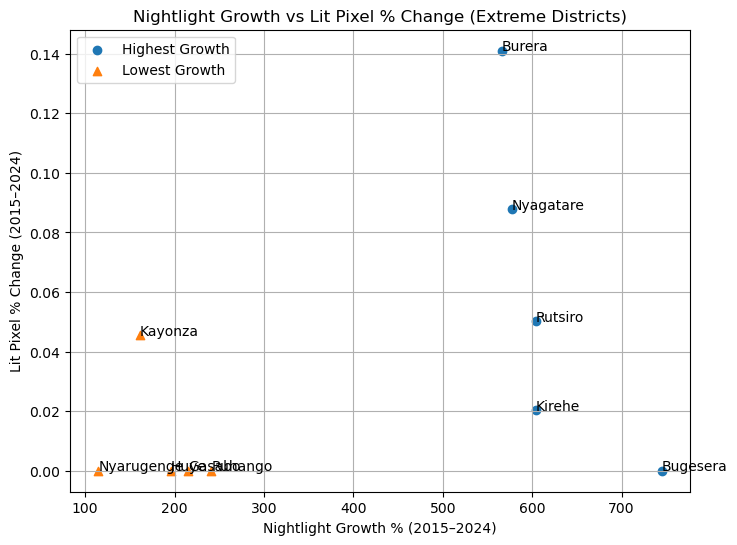

In [48]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# 1. Load dataset
DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_NTL = DIR_DATA / "cell-ntl-2015-2020-2024.csv"
df = pd.read_csv(FILE_NTL)

# 2. Remove province_name, district_name, sector_name if present
df = df.drop(columns=['province_name', 'district_name', 'sector_name'], errors='ignore')

# 3. Exclude NaNs in important columns
df = df.dropna(subset=['total_nightlight', 'lit_pixel_percentage', 'dist_name'])

# 4. Keep only 2015 & 2024 rows
df = df[df['year'].isin([2015, 2024])]

# 5. Aggregate by district & year level
agg = (
    df.groupby(['dist_name', 'year'])
      .agg(
          total_nl=('total_nightlight', 'sum'),
          mean_lit_pct=('lit_pixel_percentage', 'mean')
      )
      .reset_index()
)

# 6. Pivot wide so we have 2015 and 2024 side by side
wide = agg.pivot(index='dist_name', columns='year')
wide.columns = [f"{var}_{yr}" for var, yr in wide.columns]

# 7. Calculate nightlight growth and lit_pixel_percentage change
wide['nightlight_growth_%'] = (wide['total_nl_2024'] - wide['total_nl_2015']) / wide['total_nl_2015'] * 100
wide['lit_pixel_pct_change'] = wide['mean_lit_pct_2024'] - wide['mean_lit_pct_2015']

# 8. Sort by growth and pick top 5 and bottom 5
wide_sorted = wide.sort_values('nightlight_growth_%', ascending=False)
top5    = wide_sorted.head(5).copy()
bottom5 = wide_sorted.tail(5).copy()

# 9. Plotting
plt.figure(figsize=(8,6))
# Plot top5
plt.scatter(top5['nightlight_growth_%'], top5['lit_pixel_pct_change'], marker='o', label='Highest Growth')
# Plot bottom5
plt.scatter(bottom5['nightlight_growth_%'], bottom5['lit_pixel_pct_change'], marker='^', label='Lowest Growth')

# Annotate each point with district name
for dist, row in top5.iterrows():
    plt.annotate(dist, (row['nightlight_growth_%'], row['lit_pixel_pct_change']))
for dist, row in bottom5.iterrows():
    plt.annotate(dist, (row['nightlight_growth_%'], row['lit_pixel_pct_change']))

plt.title("Nightlight Growth vs Lit Pixel % Change (Extreme Districts)")
plt.xlabel("Nightlight Growth % (2015–2024)")
plt.ylabel("Lit Pixel % Change (2015–2024)")
plt.legend()
plt.grid(True)
plt.show()


QUESTION 2 PART C - MODELING - Multivariate Linear Regression

QUESTION 2 PART C - Multivariate Linear Regression

1. Model Development


In [21]:
# Multivariate linear regression for population density
# - Explores all numeric predictors (demographic + nightlight)
# - Handles missing values, scaling, multicollinearity (VIF)
# - Fits baseline OLS and Lasso-selected model
# - Reports R^2, RMSE/MAE, and a tidy coefficient table

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# 1) Load data

DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_CORRELATION = DIR_DATA / "correlation_10_variables.csv"
# df = pd.read_csv(FILE_CORRELATION)
df = merged_all.copy()


# 2) Identify/construct target

# Use mean_nightlight as the target variable for regression
y = merged_all["mean_nightlight"]


# 3) Build candidate feature set

# Use all numeric columns except the target and obvious identifiers
numeric = df.select_dtypes(include="number").copy()

# drop exact target if it exists in numeric
if y.name in numeric.columns:
    numeric = numeric.drop(columns=[y.name])

# Optional: drop columns that trivially define the target if we computed it
# (uncomment these lines if you computed density above and don't want leakage)
# for leak_col in ['population', 'total_population', 'pop_total', 'area_km2', 'area_sqkm', 'area']:
#     if leak_col in numeric.columns:
#         numeric = numeric.drop(columns=[leak_col])

# If you want to exclude year as a driver (often non-causal), comment this to keep it
id_like = {'cell_id','dist_id','district_id','prov_id','sector_id'}
drop_these = [c for c in numeric.columns if c.lower() in id_like]
if drop_these:
    numeric = numeric.drop(columns=drop_these)

X = numeric.copy()

# Replace inf/-inf with np.nan to avoid pipeline errors
X.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"Candidate predictors ({X.shape[1]}): {list(X.columns)}")


# 4) Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


# 5) Preprocessing pipeline

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

pre = ColumnTransformer(
    transformers=[("num", num_pipe, X.columns)],
    remainder="drop"
)


# 6) Baseline Linear Regression

base_model = Pipeline(steps=[
    ("prep", pre),
    ("linreg", LinearRegression())
])
base_model.fit(X_train, y_train)

# Evaluate
def evaluate(model, X_tr, y_tr, X_te, y_te, name="Model"):
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)
    rmse_tr = np.sqrt(mean_squared_error(y_tr, pred_tr))
    rmse_te = np.sqrt(mean_squared_error(y_te, pred_te))
    mae_te  = mean_absolute_error(y_te, pred_te)
    r2_tr   = r2_score(y_tr, pred_tr)
    r2_te   = r2_score(y_te, pred_te)
    print(f"\n{name} performance:")
    print(f"  R² train/test: {r2_tr:.3f} / {r2_te:.3f}")
    print(f"  RMSE train/test: {rmse_tr:.3f} / {rmse_te:.3f}")
    print(f"  MAE test: {mae_te:.3f}")

evaluate(base_model, X_train, y_train, X_test, y_test, name="Baseline OLS")


# 7) Multicollinearity (VIF)
#    (on imputed+scaled train features)

# Fit the preprocessor to training data only
Z_train = pre.fit_transform(X_train)
feature_names = X.columns.tolist()

vif_tbl = pd.DataFrame({
    "feature": feature_names,
    "VIF": [variance_inflation_factor(Z_train, i) for i in range(Z_train.shape[1])]
}).sort_values("VIF", ascending=False)

print("\nTop VIFs (multicollinearity check):")
print(vif_tbl.head(10).to_string(index=False))


# 8) LassoCV for feature selection

lasso = Pipeline(steps=[
    ("prep", pre),
    ("lasso", LassoCV(cv=KFold(n_splits=5, shuffle=True, random_state=42),
                      n_alphas=200, random_state=42))
])
lasso.fit(X_train, y_train)
evaluate(lasso, X_train, y_train, X_test, y_test, name="LassoCV")

# Extract non-zero coefficients on TRAIN set
# Need to refit a plain Lasso on the train preprocessed data to read coefs cleanly
pre_fitted = pre.fit(X_train, y_train)
Xtr_proc = pre_fitted.transform(X_train)
alpha = lasso.named_steps["lasso"].alpha_
from sklearn.linear_model import Lasso
lasso_plain = Lasso(alpha=alpha, random_state=42).fit(Xtr_proc, y_train)

coef = pd.Series(lasso_plain.coef_, index=feature_names)
selected = coef[coef != 0.0].sort_values(key=np.abs, ascending=False)
print("\nSelected features by Lasso (non-zero coefficients):")
print(selected)


# 9) Refit OLS on selected features (if any)

if not selected.empty:
    X_sel = X[selected.index]
    X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
        X_sel, y, test_size=0.25, random_state=42
    )

    # Create a new preprocessing pipeline for only the selected columns
    sel_num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    sel_pre = ColumnTransformer(
        transformers=[("num", sel_num_pipe, X_sel.columns)],
        remainder="drop"
    )

    sel_model = Pipeline(steps=[
        ("prep", sel_pre),
        ("linreg", LinearRegression())
    ])
    sel_model.fit(X_train_sel, y_train_sel)
    evaluate(sel_model, X_train_sel, y_train_sel, X_test_sel, y_test_sel, name="Refit OLS (Lasso-selected)")

    # Statsmodels OLS for inferential table on selected features
    Xsm_tr = pd.DataFrame(sel_pre.fit_transform(X_train_sel), columns=X_sel.columns)
    Xsm_tr = sm.add_constant(Xsm_tr)
    # Align indices for endog and exog
    y_train_sel_aligned = y_train_sel.reset_index(drop=True)
    sm_ols = sm.OLS(y_train_sel_aligned, Xsm_tr).fit()
    print("\nStatsmodels OLS (selected features) — coefficient table:")
    print(sm_ols.summary().tables[1])  # concise coef table
else:
    print("\nNo features retained by Lasso (all coefficients shrunk to zero). "
          "Consider relaxing alpha, engineering features, or removing highly collinear variables.")


# 10) Export useful artifacts (optional)

# pd.DataFrame({"feature": feature_names, "vif": [variance_inflation_factor(Z_train, i) for i in range(Z_train.shape[1])]}).to_csv("/mnt/data/vif_table.csv", index=False)
# selected.to_csv("/mnt/data/selected_features_lasso.csv", header=["coef"])


Candidate predictors (9): ['nightlight_change_2015_2024', 'mean_nightlight_change_2015_2024', 'total_nightlight', 'year', 'building_count', 'people_per_building', 'working_age_population', 'dependency_ratio', 'infrastructure_index']

Baseline OLS performance:
  R² train/test: 0.527 / 0.489
  RMSE train/test: 0.726 / 0.765
  MAE test: 0.359

Top VIFs (multicollinearity check):
                         feature          VIF
     nightlight_change_2015_2024 1.385723e+14
mean_nightlight_change_2015_2024 1.385723e+14
                dependency_ratio 5.082385e+05
            infrastructure_index 5.082286e+05
          working_age_population 4.194611e+00
                  building_count 3.902849e+00
             people_per_building 2.272234e+00
                total_nightlight 1.425578e+00
                            year 1.092414e+00

LassoCV performance:
  R² train/test: 0.524 / 0.488
  RMSE train/test: 0.728 / 0.765
  MAE test: 0.345

Selected features by Lasso (non-zero coefficients):
tota

QUESTION 2 PART C - Multivariate Linear Regression

2. Variable Selection


In [26]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# 1) Load data
DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_CORRELATION = DIR_DATA / "correlation_10_variables.csv"
# df = pd.read_csv(FILE_CORRELATION)
df = merged_all.copy()

# 2) Select target variable for regression
# Use mean_nightlight as the target variable (as in previous regression cells)
y = df["mean_nightlight"]

# 3) Candidate predictors = all numeric variables except target
num = df.select_dtypes(include="number").copy()
if y.name in num.columns:
    num = num.drop(columns=[y.name])
# Replace inf/-inf with NaN to avoid pipeline errors
num = num.replace([np.inf, -np.inf], np.nan)
X = num

# 4) Preprocessing pipeline
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# 5) Evaluate single-variable models
single_scores = {}
for col in X:
    X_col = X[[col]]
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_col, y, test_size=0.25, random_state=42)
    # Build pipeline
    pipe_single = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ])
    pipe_single.fit(X_train, y_train)
    y_pred = pipe_single.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    single_scores[col] = r2

# Print top 3 predictors by R²
top3 = sorted(single_scores.items(), key=lambda x: abs(x[1]), reverse=True)[:3]
print("Top 3 single predictors by R²:")
for name, score in top3:
    print(f"{name}: R² = {score:.3f}")


Top 3 single predictors by R²:
total_nightlight: R² = 0.314
dependency_ratio: R² = 0.285
infrastructure_index: R² = 0.285


QUESTION 2 PART C - Multivariate Linear Regression

3. Model Evaluation


In [27]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# 1) Load data
DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_CORRELATION = DIR_DATA / "correlation_10_variables.csv"
# df = pd.read_csv(FILE_CORRELATION)
df = merged_all.copy()

# 2) Select target variable for regression
# Use mean_nightlight as the target variable (as in previous regression cells)
y = df["mean_nightlight"]

# 3) Candidate predictors = all numeric variables except target
num = df.select_dtypes(include="number").copy()
if y.name in num.columns:
    num = num.drop(columns=[y.name])
# Replace inf/-inf with NaN to avoid pipeline errors
num = num.replace([np.inf, -np.inf], np.nan)
X = num

# 4) Preprocessing pipeline
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# 5) Evaluate single-variable models
single_scores = {}
for col in X:
    X_col = X[[col]]
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_col, y, test_size=0.25, random_state=42)
    # Build pipeline
    pipe_single = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ])
    pipe_single.fit(X_train, y_train)
    y_pred = pipe_single.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    single_scores[col] = r2

# Print top 3 predictors by R²
top3 = sorted(single_scores.items(), key=lambda x: abs(x[1]), reverse=True)[:3]
print("Top 3 single predictors by R²:")
for name, score in top3:
    print(f"{name}: R² = {score:.3f}")

# Pick top 3 predictors from your earlier results
top3_predictors = [name for name, _ in top3]   # list of column names
X_top3 = df[top3_predictors]

# Add constant term for intercept
X_top3 = sm.add_constant(X_top3)

# Fit OLS regression
model = sm.OLS(y, X_top3, missing="drop").fit()

print(model.summary())

Top 3 single predictors by R²:
total_nightlight: R² = 0.314
dependency_ratio: R² = 0.285
infrastructure_index: R² = 0.285
                            OLS Regression Results                            
Dep. Variable:        mean_nightlight   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     3406.
Date:                Wed, 20 Aug 2025   Prob (F-statistic):               0.00
Time:                        23:46:11   Log-Likelihood:                -7270.9
No. Observations:                6504   AIC:                         1.455e+04
Df Residuals:                    6501   BIC:                         1.457e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]

INTERPRETATION:

Nightlight intensity (proxy for economic activity + infrastructure) rises with building count and working-age population, confirming that infrastructure and demographics are tightly linked.

A negative coefficient on the dependency ratio suggests that areas with high child/elderly burden are less economically active, even if population is high.

Strong R² values would confirm that nightlight is a good proxy for population-infrastructure interactions.
